In [6]:
import pandas as pd
import numpy as np

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from random import randint as rand
from math import log, pi as PI

In [7]:
stations = pd.read_csv('data/station.csv', low_memory = False)

stations.rename(columns = {'installation_date':'date',
                           'long'             :'lon'
                          }, inplace = True)

# Cambio el formato de las fechas
stations['date'] = pd.to_datetime(stations['date'])

In [8]:
trips = pd.read_csv('data/trip.csv', low_memory = False)

#Eliminamos este dato ya que no sera relevante para estos analisis
del(trips['zip_code'])

trips.rename(columns = {'start_date'        :'s_date' ,
                        'end_date'          :'e_date' ,
                        'start_station_name':'ss_name',
                        'start_station_id'  :'ss_id'  ,
                        'end_station_name'  :'es_name',
                        'end_station_id'    :'es_id'  ,
                        'subscription_type' :'subs'
                       }, inplace = True)

# Cambio el formato de las fechas y tiempos de incio y fin de cada viaje
trips['s_date'] = pd.to_datetime(trips['s_date'], format = '%m/%d/%Y %H:%M')
trips['e_date'] = pd.to_datetime(trips['e_date'], format = '%m/%d/%Y %H:%M')

In [10]:
#Quitamos los viajes de duracion menor o igual a 3 minutos (180 segundos) y que de la misma estacion,
#ya que pueden ser rutinas de mantenimiento o reparacion, etc
trips = trips[-((trips['duration'] <= 180) & \
                (trips['ss_id'] == trips['es_id']))]

# Ordeno los viajes por id
trips = trips.sort_values(by = 'id')

### Suscriptores vs Clientes

Quienes utilizan mas el servicio? Suscriptores o clientes comunes?

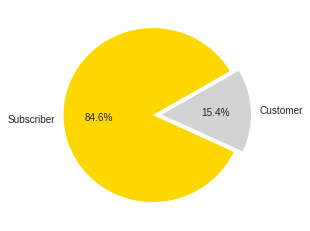

In [64]:
subs = trips.groupby('subs').count()[['id']]

plt.figure(figsize = (4, 4))
plt.pie(subs.values,
        explode = (0.1, 0),
        labels = subs.index.values,
        startangle = -25,
        colors = ['lightgrey', 'gold'],
        autopct = '%1.1f%%'
       )
plt.savefig('visu_subs_vs_cust.png')
plt.show()

Aqui se ve que la mayoria de los usuarios del servicio, estan suscriptos a este mismo.

### Visualizacion de la cantidad de bicicletas de todas las estaciones

Lo que se quiere lograr es ver la proporcion de uso de bicicletas entre estaciones

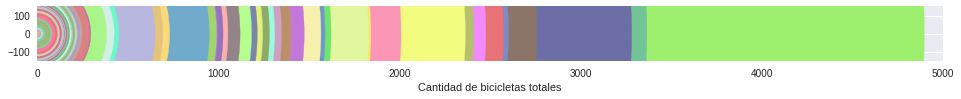

In [14]:
#Obtenemos la cantidad total de viajes iniciados en cada estacion
estaciones_uso = trips.groupby('ss_name')['id'].count().sort_values(ascending = False)

#Por motivos de visualizacion, escalo la cantidad de viajes iniciados de cada estacion
estaciones_uso = estaciones_uso.map(lambda x:float(x)/10).values

fig, ax = plt.subplots()
ax.set_aspect(1)
ax.set_xlim((0, 5000))
ax.set_ylim((-150, 150))
fig.set_size_inches(20, 1)

for i in range(estaciones_uso.shape[0]):
    ax.add_artist(plt.Circle((0, 0), estaciones_uso.values[i], color = '#%02X%02X%02X' % (rand(100, 255), rand(100, 255), rand(100, 255))))

plt.savefig('visu_comparacion_estaciones.png');
plt.xlabel('Cantidad de bicicletas totales');
plt.show();

### Uso de Estaciones por candtidad de bicicletas totales

In [15]:
trips_13_15 = trips
trips_2013  = trips[          trips['s_date']  < '2014'                    ].reset_index()
trips_2014  = trips[('2014' < trips['s_date']) & (trips['s_date'] < '2015')].reset_index()
trips_2015  = trips[ '2015' < trips['s_date']                              ].reset_index()

viajes_por_anio = [trips_13_15, trips_2013, trips_2014, trips_2015]
anios = ['2013-2015', '2013', '2014', '2015']

#Calculamos la suma de bicicletas que partieron de las estaciones usadas en cada año
for i in range(len(viajes_por_anio)):
    viajes_por_anio[i] = viajes_por_anio[i].groupby('ss_name')['id'].count().sort_values(ascending = False)

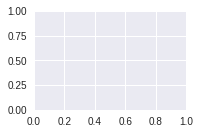

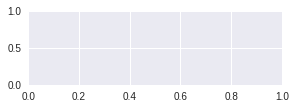

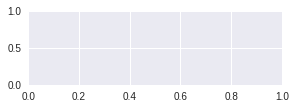

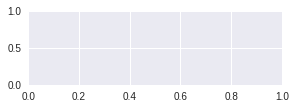

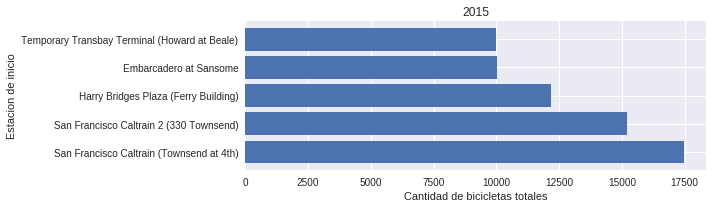

In [16]:
##Para este plot quiero que los subplots tengan el mismo rango en los ejes
##despues veo bien como se hace

plt.figure(figsize = (20, 7))

for i in range(len(viajes_por_anio)):
    plt.subplot(221 + i);
    #plt.figure(figsize = (10, 3));
    plt.title(anios[i]);
    plt.xlabel('Cantidad de bicicletas totales');
    plt.ylabel('Estacion de inicio');
    plt.barh([c for c in range(5)],
             [c for c in viajes_por_anio[i][:5].values],
             tick_label = [c for c in viajes_por_anio[i][:5].index.values])
    plt.savefig('viajes_' + anios[i] + '.png')

plt.tight_layout()

### Visualizando con mapas

In [79]:
def distancia_grados(dist):
    '''funcion para calcular grados a partir de una distancia'''
    return (180 * dist) / (6371 * PI)

def distancia_km(angulo):
    return angulo * 6371 * PI / 180

#offset = distancia_grados(40, 6371)
# convertir 40km a grados. El otro parametro es el radio de la tierra (en km)

def mean(a, b):
    return (a + b) / 2

In [73]:
#Calculamos la cantidad de bicicletas por cada estacion
bicis_por_estacion = trips.groupby('ss_id').count()[['ss_name']].reset_index()

bicis_por_estacion.rename(columns = {'ss_id' :'id',
                                     'ss_name':'count'
                                    }, inplace = True)

#Agregamos el nombre de la estacion, la ciudad en donde queda y sus coordenadas
estaciones = pd.merge(stations.drop(['date', 'dock_count'], 1), bicis_por_estacion, on = 'id')

### Frecuencia de uso de Estaciones por ciudad

Lo que se quiere ver ahora es, como se distribuyen los viajes realizados entre las estaciones de cada ciudad.
(se utiliza la cantidad de bicicletas que parten de una estacion como medida de frecuencia de uso de una estacion)

In [132]:
#Separamos las estaciones por ciudad
sf = estaciones[estaciones['city'] == 'San Francisco'].reset_index(drop = True)
sj = estaciones[estaciones['city'] == 'San Jose'     ].reset_index(drop = True)
mv = estaciones[estaciones['city'] == 'Mountain View'].reset_index(drop = True)
pa = estaciones[estaciones['city'] == 'Palo Alto'    ].reset_index(drop = True)
rc = estaciones[estaciones['city'] == 'Redwood City' ].reset_index(drop = True)

ciudades = [sf, sj, mv, pa, rc, estaciones]
nombres  = ['San Francisco', 'San Jose', 'Mountain View', 'Palo Alto', 'Redwood City', 'Bay']
ciudades_cant_estaciones = []
ciudades_bicis = []

#Listas con latitudes y longitudes de cada ciudad
lats = []
lons = []

offsets = []

#Para cada ciudad, vemos su cantidad de estaciones y la cantidad total de bicicletas
for ciudad in ciudades:
    ciudades_cant_estaciones.append(ciudad.shape[0])
    ciudades_bicis.append(ciudad['count'].sum())
    #Para incluir a todas las estaciones (en la visualizacion), tomamos la media entre la coordenada maxima y minima
    lat_max, lat_min = ciudad['lat'].max(), ciudad['lat'].min()
    lon_max, lon_min = ciudad['lon'].max(), ciudad['lon'].min()
    lats.append(mean(lat_max, lat_min))
    lons.append(mean(lon_max, lon_min))
    #Scope indica cuanto
    #scope.append(max(distancia_km(lat_max - lat_min) * 0.6, distancia_km(lon_max - lon_min) * 0.6))
    offsets.append(max((lat_max - lat_min) * 0.6, (lon_max - lon_min) * 0.6))

#La cantidad de estaciones se va a utilizar para escalar a los tamaños de las estaciones en la visualizacion

In [101]:
#Seteamos algunas variables para los mapas
proyeccion = 'merc'
resolucion = 'l'
epsg = 4326
color = 'tomato'
servicio = 'NatGeo_World_Map'
x_tam, y_tam = 500, 500 #1000, 1000
#radio_tierra_km = 6371
marcador = 'o'

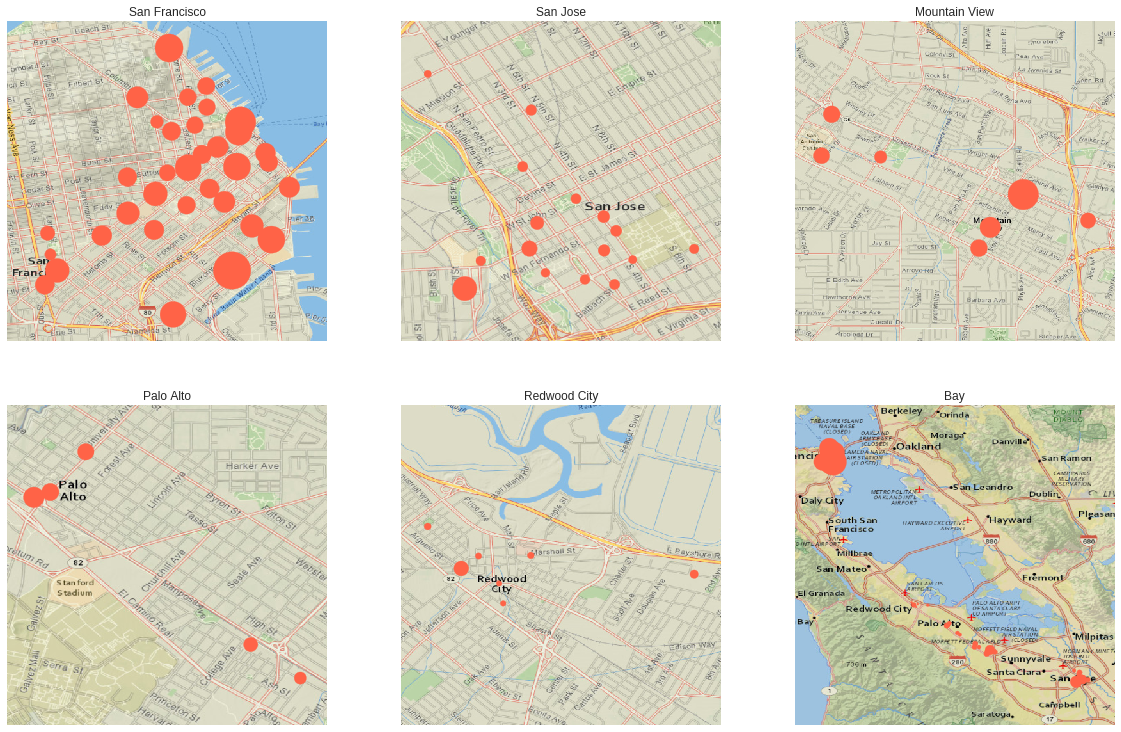

In [133]:
plt.figure(figsize = (20, 20))

for i in range(len(ciudades)):
    plt.subplot(331 + i);
    plt.title(nombres[i]);
    #offset = distancia_grados(scope[i])
    mapa = Basemap(projection = proyeccion, resolution = resolucion, epsg = epsg, 
                   llcrnrlat = lats[i] - offsets[i], llcrnrlon = lons[i] - offsets[i], 
                   urcrnrlat = lats[i] + offsets[i], urcrnrlon = lons[i] + offsets[i])
    
    #Ploteamos las estaciones e indicamos frecuencia de uso segun la cantidad de viajes inciados desde esa estacion
    #Aqui se escalan los tamaños de las estaciones dependiendo de la ciudad que se muestre
    mapa.scatter(ciudades[i]['lon'].values, ciudades[i]['lat'].values, 
                 marker = marcador, c = color, s = ciudades[i]['count'].apply(lambda x:x/ciudades_cant_estaciones[i]));
    
    mapa.arcgisimage(service = servicio, xpixels = x_tam, ypixels = y_tam);
    plt.savefig(nombres[i] + '_map.png');
    

### Comparando todas las ciudades

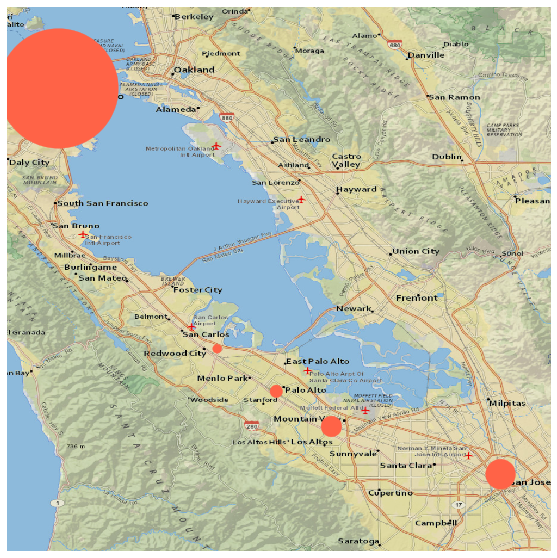

In [22]:
#Buscando la coordenada media entre todas las estaciones para centrar al mapa
max_lat, max_lon = station_bikes.max()[['lat', 'lon']]
min_lat, min_lon = station_bikes.min()[['lat', 'lon']]
lat, lon = mean(max_lat, min_lat), mean(max_lon, min_lon)

plt.figure(figsize = (10, 10))
offset = distancia_grados(35)
mapa = Basemap(projection = proyeccion, resolution = resolucion, epsg = epsg, 
               llcrnrlat = lat - offset, llcrnrlon = lon - offset, 
               urcrnrlat = lat + offset, urcrnrlon = lon + offset)
  
mapa.scatter(lons, lats, s = ciudades_bicis, marker = marcador, c = color)

mapa.arcgisimage(service = servicio, xpixels = x_tam,  ypixels = y_tam)
plt.savefig('bahia_viajes_ciudades.png')
plt.show()

### Comparando viajes por ciudad

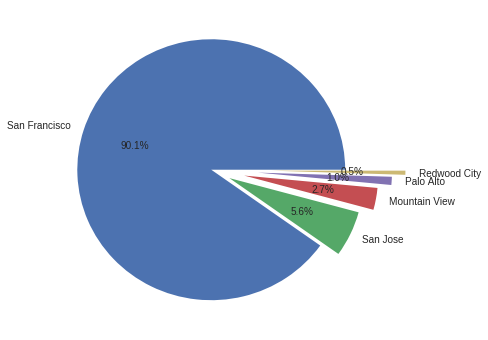

In [113]:
plt.figure(figsize = (6, 6))
plt.pie(ciudades_bicis[:-1:], labels = nombres[:-1:], autopct = '%1.1f%%', explode = (0, .15, .25, .35, .45) )
plt.show()

La gran parte de los viajes parten de estaciones ubicadas en la ciudad de San Francisco

In [24]:
#Dataframe con los nombres de todas las estaciones y sus coordenadas
ss_location = stations[['name', 'lat', 'lon', 'city']]
ss_location.rename(columns = {'name':'ss_name', 
                              'lat' :'s_lat', 
                              'lon' :'s_lon', 
                              'city':'s_city'
                             }, inplace = True)

es_location = stations[['name', 'lat', 'lon', 'city']]
es_location.rename(columns = {'name':'es_name', 
                              'lat' :'e_lat', 
                              'lon' :'e_lon', 
                              'city':'e_city'
                             }, inplace = True)

#Estos dataframes seran combinados con los de trayectos por la columna que tengan en comun
#En este caso, se quiere obtener un dataframe con 2 estaciones (inicial y final) con sus coordenadas y viajes

/home/mk/datos/benv/lib/python2.7/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


### Trayectos mas frecuentes

Lo que queremos lograr ahora es, ver cuales son los viajes entre estaciones mas utilizados.

Ademas de calcular los trayectos hay que juntar los que estan repetidos. Los trayectos con mas repeticiones seran considerados como los mas frecuentes.

In [51]:
trayectos_frec = trips[['id', 'ss_name', 'es_name']].groupby(['es_name', 'ss_name'], as_index = False).count()

trayectos_frec.rename(columns = {'id':'count'}, inplace = True)

In [28]:
def reducir_trayectos(trayectos_frec):
    #El trayecto A -> B es el mismo que B -> A
    #Esta funcion junta las repeticiones de estos trayectos
    l = [] 
        #Lista con indice del dataframe del trayecto eliminado
    for i in range(len(trayectos_frec)): 
            #Por cada trayecto
        if i not in l:
            #Si esta en el dataframe
            prim = trayectos_frec.loc[i]
                #Obtenemos el trayecto actual
            for j in range(i, len(trayectos_frec)): 
                #Buscamos en lo que resta del dataframe
                if j not in l: 
                    #Si el trayecto que queremos ver, esta en el dataframe
                    seg = trayectos_frec.loc[j] 
                        #Lo guardamos
                    if prim['ss_name'] == seg['es_name'] and prim['es_name'] == seg['ss_name']: 
                        #Si coinciden los trayectos
                        trayectos_frec.loc[i]['count'] += trayectos_frec.loc[j]['count']
                            #Sumamos los trayectos
                            #Nosotros consideramos que los trayectos de A a B son iguales que los de B a A
                            #Pero en el dataframe no estan asi, por eso sumamos los viajes
                        trayectos_frec.drop(j, inplace = True)
                            #Quitamos al segundo trayecto del dataframe
                        l.append(j)
                            #Lo colocamos en la lista, para que no halla error luego
    return trayectos_frec

#Esta funcion, puede tomar un tiempo
#Si saben como hacerlo mas eficiente, modifiquenlo pls

tf = reducir_trayectos(trayectos_frec)

# Añadimos al dataframe, las ubicaciones de cada estacion
tf = pd.merge(tf, ss_location, on = 'ss_name')
tf = pd.merge(tf, es_location, on = 'es_name')

/home/mk/datos/benv/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
#Este diccionario se va a contener, por ciudad:
#    . lista de tuplas del estilo ([lons], [lats], color) que tienen las coord de estaciones de un trayecto y su color
#    . lista de los trayectos de la ciudad
#respectivamente. Esto es para automatizar y tambien para colocar a todos los mapas en un subplot (de matplotlib)
viajes = {'San Francisco': [[], []], 
          'San Jose'     : [[], []], 
          'Redwood City' : [[], []], 
          'Mountain View': [[], []], 
          'Palo Alto'    : [[], []]
         }

for ciudad in viajes:
    #Filtramos los trayectos por ciudad
    #Aqui se quitan los trayectos con estaciones en distintas ciudades
    viajes[ciudad][1] = tf[(tf['s_city'] == ciudad) & \
                           (tf['e_city'] == ciudad)].drop(['s_city', 'e_city'], 1).reset_index(drop = True)
    
    #Calculamos la cantidad maxima de viajes por cada trayecto en cada ciudad
    #Esto es para luego asignar colores a trayectos con mas o menos frecuencia
    max_val = 0
    for indice in range(len(viajes[ciudad][1])):
        trayecto = viajes[ciudad][1].loc[indice]
        if trayecto['count'] > max_val: 
            max_val = trayecto['count']
    
    #Colocamos longitud y latitud de un trayecto ademas de su frecuencia convertida a un numero en [0;255]
    for indice in range(len(viajes[ciudad][1])):
        trayecto = viajes[ciudad][1].loc[indice]
        #Mapeo de la frecuencia del trayecto al intervalo [0;255]
        color = int(255 / float(max_val) * trayecto['count'])
        color = abs(255 - color)
        viajes[ciudad][0].append(([trayecto.['s_lon'], trayecto.['e_lon']],
                                  [trayecto.['s_lat'], trayecto.['e_lat']],
                                  color)
                                )
    #Ordenamos los viajes mas frecuentes al final, asi son mostrados por encima de los trayectos menos frecuentes
    viajes[ciudad][0].sort(key = lambda x: -x[2])

/home/mk/datos/benv/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/mk/datos/benv/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


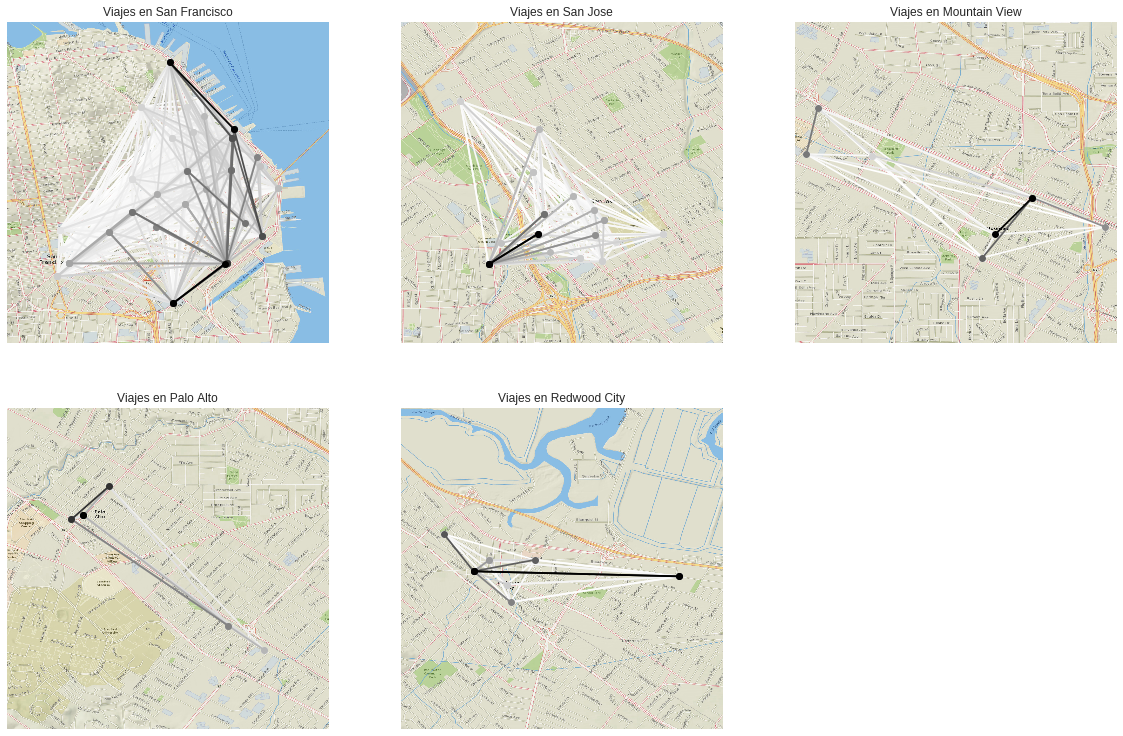

In [32]:
#Ahora visualizamos los trayectos por ciudad

plt.figure(figsize = (20, 13))

for i in range(len(ciudades)):
    plt.subplot(231 + i);
    plt.title('Viajes en ' + nombres[i]);
    offset = distancia_grados(2.5)
    mapa = Basemap(projection = proyeccion, resolution = resolucion, epsg = epsg, 
                   llcrnrlat = lats[i] - offset, llcrnrlon = lons[i] - offset, 
                   urcrnrlat = lats[i] + offset, urcrnrlon = lons[i] + offset)
    
    for trayecto in viajes[nombres[i]][0]:
        #Convertimos el color a un formato RGBA valido
        color = trayecto[2]
        color = '#%02X%02X%02X' % (color, color, color)
        #Ploteamos el trayecto
        mapa.plot(trayecto[0], trayecto[1], 'o-', color = color)
    
    mapa.arcgisimage(service = servicio, xpixels = x_tam, ypixels = y_tam);
    plt.savefig(nombres[i] + '_map_viajes.png');

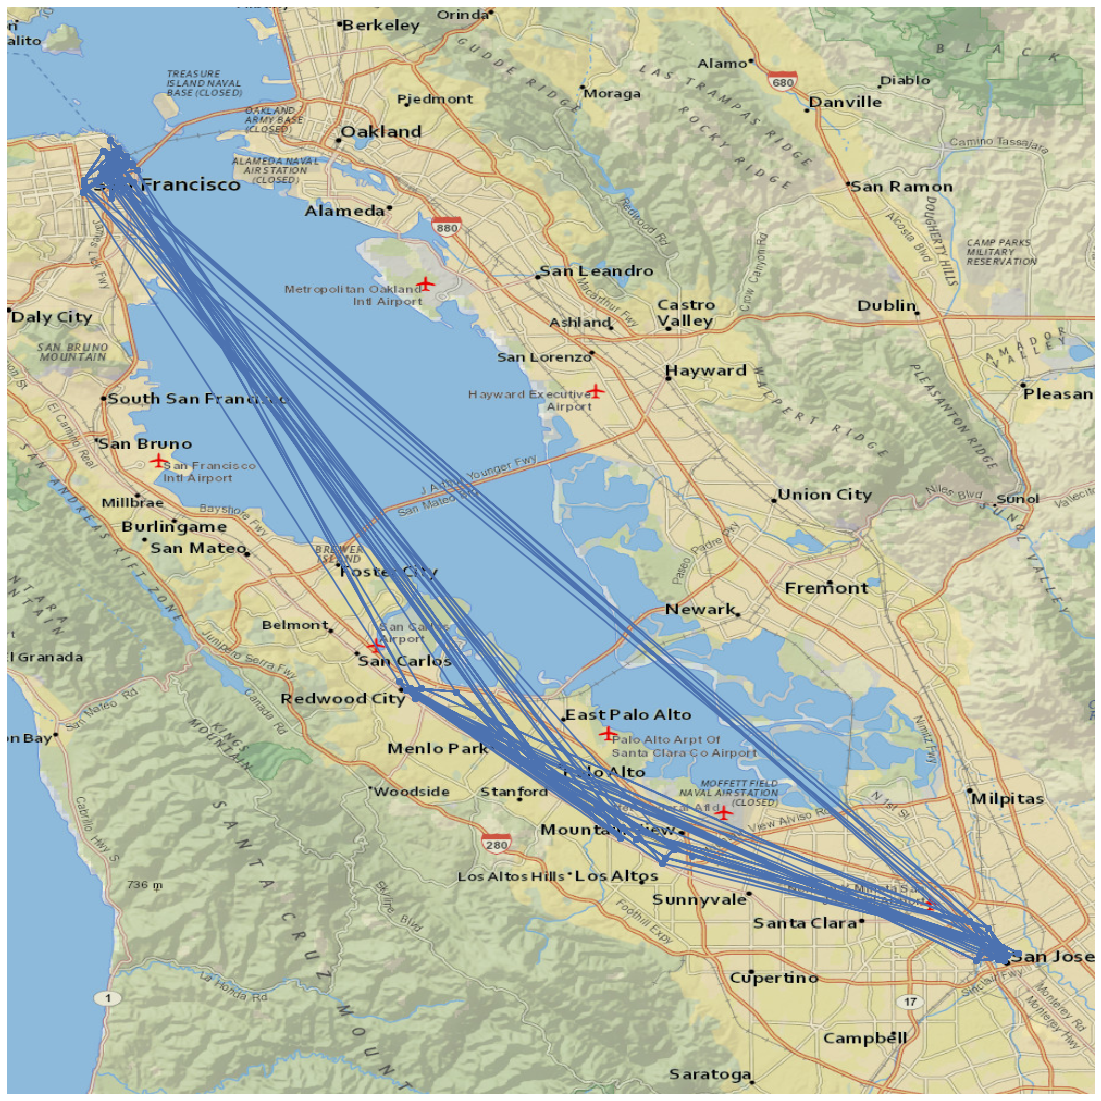

In [33]:
#Esto falta editarlo un poco mas, para que quede lindo (ahora son solo lineas azules)
#Es un mapa de toda la bahia con todos los viajes realizados (conecta estacion inicial con final por cada viaje)

plt.figure(figsize = (10, 10))
offset = distancia_grados(35)
mapa = Basemap(projection = proyeccion, resolution = resolucion, epsg = epsg, 
               llcrnrlat = lat - offset, llcrnrlon = lon - offset, 
               urcrnrlat = lat + offset, urcrnrlon = lon + offset )

mapa.plot(tf['s_lon'], tf['s_lat'], 'o-' )

mapa.arcgisimage(service = servicio, xpixels = x_tam, ypixels = y_tam)
plt.show()

In [50]:
trayectos_frec[trayectos_frec['ss_name'] == 'Market at 10th']

es_name         ss_name  count
18                                    2nd at Folsom  Market at 10th    272
55                                2nd at South Park  Market at 10th    340
92                                  2nd at Townsend  Market at 10th    195
129                                   5th at Howard  Market at 10th    501
202                                 Beale at Market  Market at 10th    396
239                       Broadway St at Battery St  Market at 10th     45
311               Civic Center BART (7th at Market)  Market at 10th    836
351                                 Clay at Battery  Market at 10th     97
388                        Commercial at Montgomery  Market at 10th    157
442                                Davis at Jackson  Market at 10th    170
479                           Embarcadero at Bryant  Market at 10th     64
516                           Embarcadero at Folsom  Market at 10th     65
553                          Embarcadero at Sansome  Market at 10th    191
590                          Embarcadero at Vallejo  Market at 10th    127
650                             Golden Gate at Polk  Market at 10th    185
687                 Grant Avenue at Columbus Avenue  Market at 10th    189
724            Harry Bridges Plaza (Ferry Building)  Market at 10th    426
762                                   Howard at 2nd  Market at 10th    219
1419                        San Francisco City Hall  Market at 10th    107
1595                       South Van Ness at Market  Market at 10th    251
1632                                Spear at Folsom  Market at 10th    178
1699                              Steuart at Market  Market at 10th    534
1736  Temporary Transbay Terminal (Howard at Beale)  Market at 10th    339
1773                                Townsend at 7th  Market at 10th    831
1827                          Washington at Kearney  Market at 10th     92
1862                           Washington at Kearny  Market at 10th    183
1897  Yerba Buena Center of the Arts (3rd @ Howard)  Market at 10th    630